In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulse2percept.datasets import load_perezfornos2012
import time
from pulse2percept.models import TemporalModel
from pulse2percept.stimuli.pulse_trains import BiphasicPulseTrain
from scipy.optimize import minimize, differential_evolution
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
from scipy.stats import pearsonr
import pandas as pd

In [2]:
data = load_perezfornos2012()
# data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')

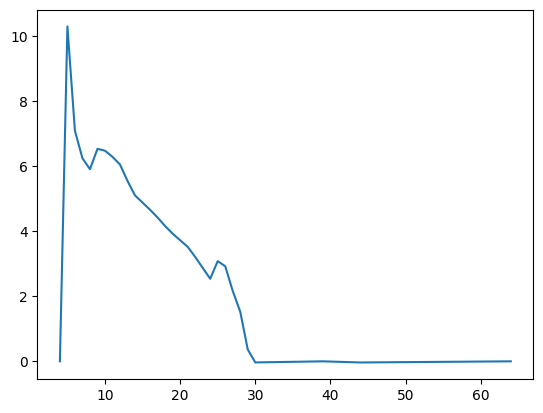

In [3]:
plt.plot(data['time_series'][0])

## test

In [ ]:
# fixed parameters
SigmaX=.4 # phosphene dimension in x axis
SigmaY=.4 # phosphene dimension in y axis
X0=24  # distance between two adjecent phosphenes in x axis
Y0=24  # distance between two adjecent phosphenes in y axis
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

va = 0
vb = 0.333
vc = 0.667
vd = 1
MMr = 6  # number of rows
MMc = 10  # number of columns;
C = 240  # number of pixel columns
R = 144 # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24
v2 = 0
v3 = 0
count = 0

# fit parameters
DFR=60 # display frame rate (usually 30 or 60 FPS)
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
brightness_scale = 10

# fixed parameters - condition dependent
EAR=6  # electrode activation rate (usually 6 or 10 Hz)
exper_dur = 60  # experiment duration
stim_dur = 10  # stimulus duration

In [ ]:
PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
PF_Factor = PFO*EAR

# Creating meshgrid
x = np.arange(0, C)  # in Python, np.arange() starts from 1 to C inclusive
y = np.arange(0, R)  # in Python, np.arange() starts from 1 to R inclusive
X, Y = np.meshgrid(x, y)
# Initialization
z = np.zeros((R, C))
Frame = np.zeros((R, C))
FormerFrame = np.zeros((R, C))
PFC = np.zeros((MMr, MMc))
Theta = np.zeros((MMr, MMc))
a = np.zeros((MMr, MMc))
b = np.zeros((MMr, MMc))
c = np.zeros((MMr, MMc))
sigma_x = np.zeros((MMr, MMc))
sigma_y = np.zeros((MMr, MMc))

count = 0
for s in range(MMr):
    for t in range(MMc):
        Theta[s, t] = 0
        sigma_x[s, t] = SigmaX
        sigma_y[s, t] = SigmaY
        a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                  (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
        b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                   (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
        c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                  (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)


In [ ]:
I_frame = [1]*(stim_dur)*MMr*MMc  # the brightness of the video is always 1
I_frame_0 = [0]*(exper_dur-stim_dur)*MMr*MMc  # no visual input after 30s
I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
I_frame = np.array(I_frame).reshape(exper_dur, MMr, MMc)

results = []

for frame in range(exper_dur):
    I = I_frame[frame]
    # I = I / I.max()
    MeanMatrix = np.zeros((MMr, MMc))
    s = 0
    t = 0
    v = 0

    start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
    stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
    step = -int(np.floor(I.shape[0] / MMr))
    for m in range(start, stop, step):
        for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
            for j in range(m, m - (I.shape[0] // MMr), -1):
                # for k in range(n, n + (I.shape[1] // MMc)-2):
                for k in range(n, n - (I.shape[1] // MMc), -1):
                    v += I[j, k]
            v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

            if 0 <= v <= 0.25:
                v = va
            elif 0.25 < v <= 0.5:
                v = vb
            elif 0.5 < v <= 0.75:
                v = vc
            else:
                v = vd
            MeanMatrix[s, t] = v
            v = 0
            t += 1
        t = 0
        s += 1

    getting_all_subframe = []
    for SubFrame in range(1, DFR // EAR + 1):
        for s in range(MMr):
            for t in range(MMc):
                adjusted_t = t + 1
                adjusted_s = s + 1
                z += MeanMatrix[s, t] * np.exp(
                    # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                    -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                    # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                    (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                    # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                    2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                    # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                    c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

            v2 -= (X0 / 2) * v3
            v3 *= -1

        for s in range(R, 0, -X0):
            for t in range(0, C, Y0):
                if SubFrame == 1:
                    condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                    condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                    condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                    condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                    if condition1 or condition2 or condition3 and condition4:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        # Frame(s-X0+1:s,t:t+Y0-1) = exp(-PER_Factor)*FormerFrame(s-X0+1:s,t:t+Y0-1);
                    elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                        PFC[s//X0-1, t//Y0] += 1
                        # elseif mean(mean(z(s-X0+1:s,t:t+Y0-1))) >= mean(mean(FormerFrame(s-X0+1:s,t:t+Y0-1)))...
                            # && PFC(s/X0,floor(t/Y0)+1) < PF_Factor%*(1+(2/5)*(rand-0.5))
                        # Frame(s-X0+1:s,t:t+Y0-1) = z(s-X0+1:s,t:t+Y0-1) ;
                        # PFC(s/X0,floor(t/Y0)+1) = PFC(s/X0,floor(t/Y0)+1) + 1;
                    elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        # elseif PFC(s/X0,floor(t/Y0)+1) >= PF_Factor%*(1+(2/5)*(rand-0.5))
                        # Frame(s-X0+1:s,t:t+Y0-1) = exp(-3*PER_Factor)*FormerFrame(s-X0+1:s,t:t+Y0-1);
                else:
                    Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
                    # Frame(s-X0+1:s,t:t+Y0-1) = exp(-PER_Factor)*Frame(s-X0+1:s,t:t+Y0-1);
        z = np.zeros((R,C))
        count = count + 1

        FormerFrame = Frame
        getting_all_subframe.append(Frame.max())
    results.append(max(getting_all_subframe))

output =  [x * brightness_scale for x in results]

In [ ]:
plt.plot(output)

## train

In [ ]:

def brightness_equ(PER, PFO, PFD, brightness_scale):
    # fixed parameters
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    # X0=24  # distance between two adjecent phosphenes in x axis
    # Y0=24  # distance between two adjecent phosphenes in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1
    # MMr = 6  # number of rows
    # MMc = 10  # number of columns;
    # C = 240  # number of pixel columns
    # R = 144 # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_


In [ ]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [ ]:
import numpy as np
from scipy.optimize import minimize
# def objective_function(params, ground_truth):
#     # display frame rate, persistence time, fading time, brightness scale
#     DFR, PER, PFO, brightness_scale = params
   
#     model_output = brightness_equ(DFR, PER, PFO, brightness_scale)
    
#     mse = np.mean((np.array(model_output) - ground_truth) ** 2)
#     print(mse)
#     return mse


# for i in range(0,1):
#     current_time = datetime.now()
#     formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
#     if i <= 8: args.EAR = 20
#     elif i <= 17: args.EAR = 5
#     else: args.EAR = 60
        
    # args.EAR = 20
    # if i<=35: 
    #     args.exper_dur = 20
    #     args.stim_dur = 2
    # else: 
    #     args.exper_dur = 140
    #     args.stim_dur = 120
        
    # curve = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur+4]
    # ground_truth = curve  
    # Initial guesses for parameters
    # initial_params = [60, 2, 10, 10]
    # # Run the optimization, passing the ground truth as an argument
    # result = minimize(objective_function, initial_params, args=(ground_truth,), method='Nelder-Mead')
    # # Extract optimized parameters
    # optimized_params = result.x
    # print("Optimized Parameters:", optimized_params)
    
    # file_path = '/hdd/yuchen/temporal_results.txt'  
    # line_to_add = '' 
    # line_to_add += str(i) + ': '
    # line_to_add += str(optimized_params) + '\n' + formatted_time + '\n'
    # with open(file_path, 'a') as file:
    #     file.write(line_to_add)

## eval 

### per-subject 0.5 interp

In [ ]:
def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

file_path = '/hdd/yuchen/baseline_test.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list

In [ ]:
# validation score
# ct, r2, mse, cor = 0,0,0,0
ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]

    gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]


    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)
    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure()
    plt.plot(gt_curves_val)
    plt.plot(pred)
    plt.title('mse: '+str(mse[i]))
    
    # if ct == 9:
    #     print('mse:', round(mse/9, 5))
    #     print('r2:', round(r2/9, 5))
    #     print('cor:', round(cor/9, 5))
    #     ct, r2, mse, cor = 0,0,0,0

In [ ]:
for cond in range(5):
    mse_,r2_,cor_ = [],[],[]
    for subj in range(9):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    print('cond', cond)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3))
    print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

In [ ]:
for subj in range(9):
    mse_,r2_,cor_ = [],[],[]
    for cond in range(5):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    print('subject', subj)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3))
    print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

### per-subject 0.25 interp (trained on 0.25)

In [5]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


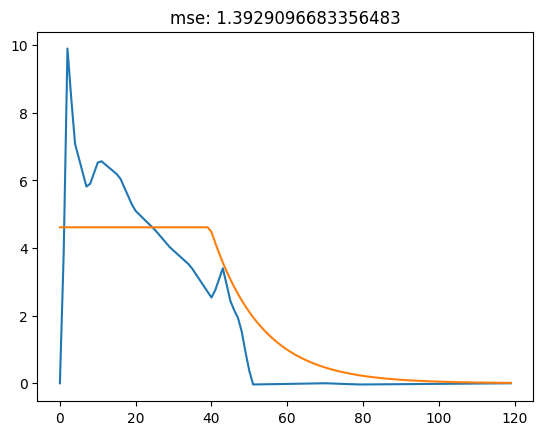

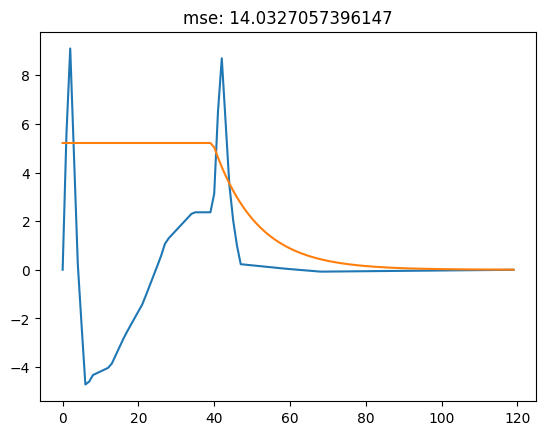

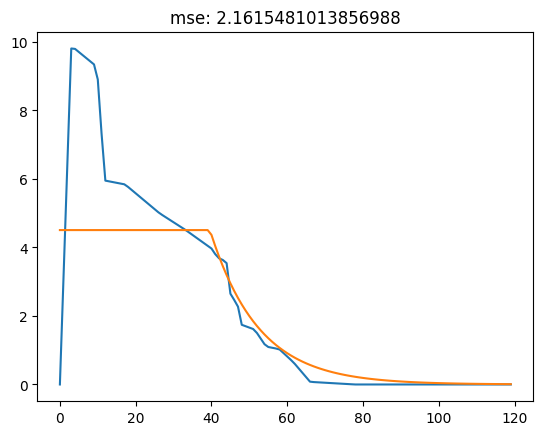

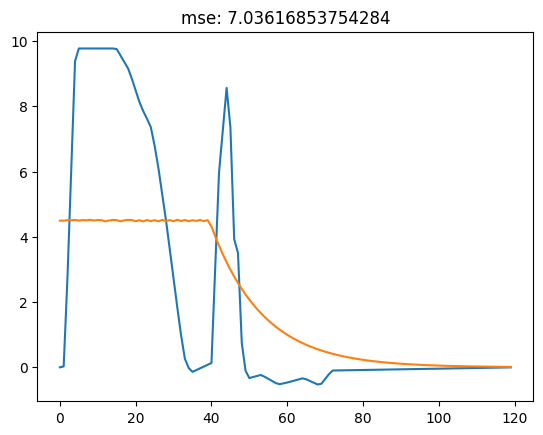

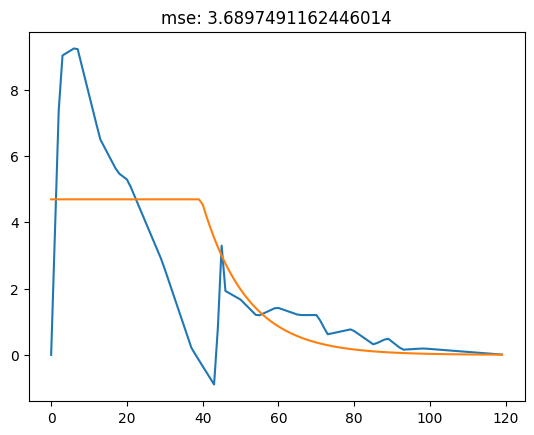

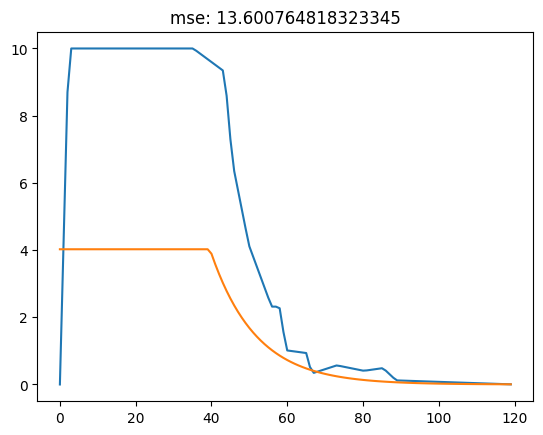

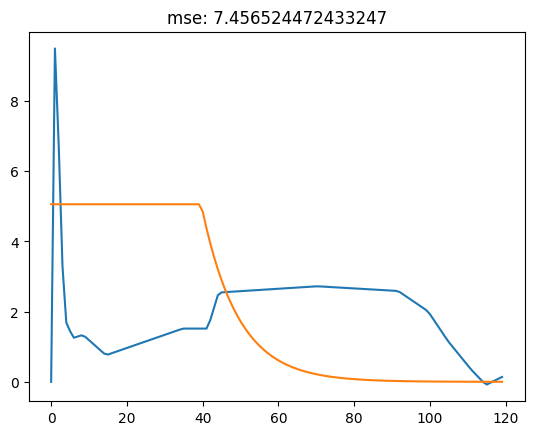

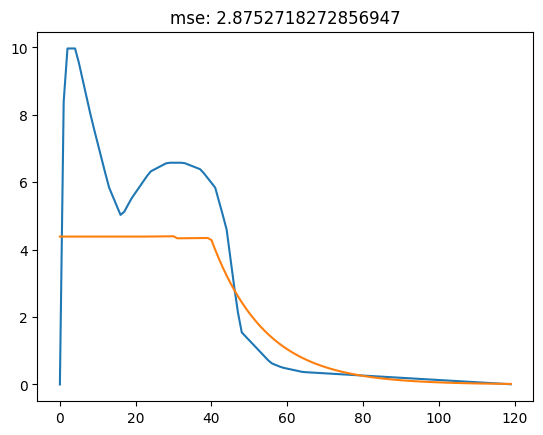

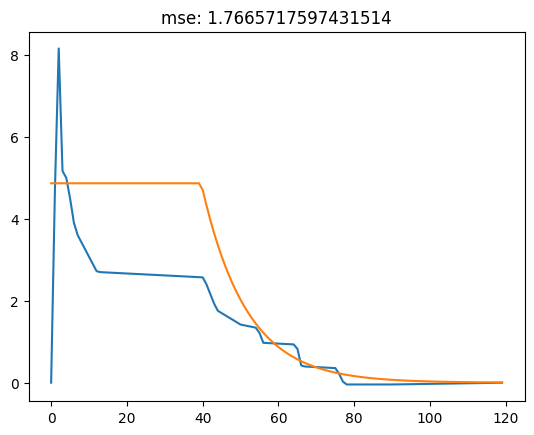

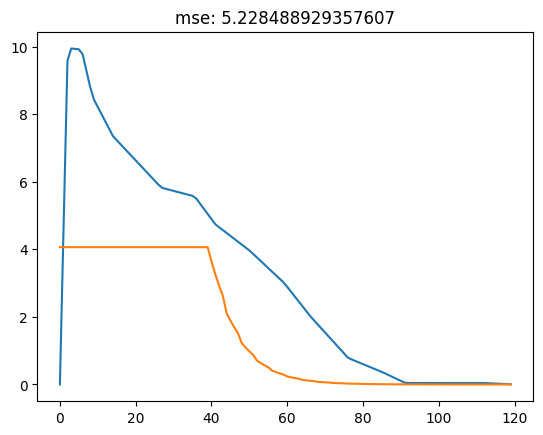

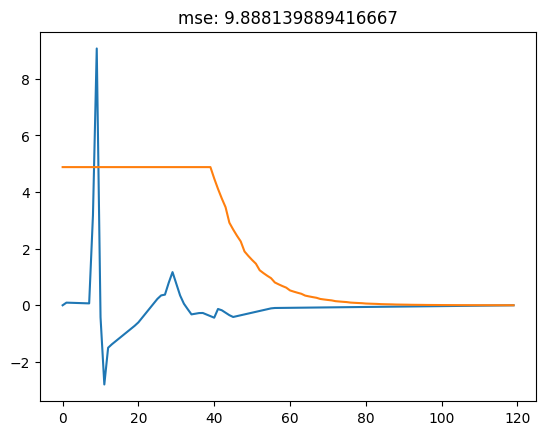

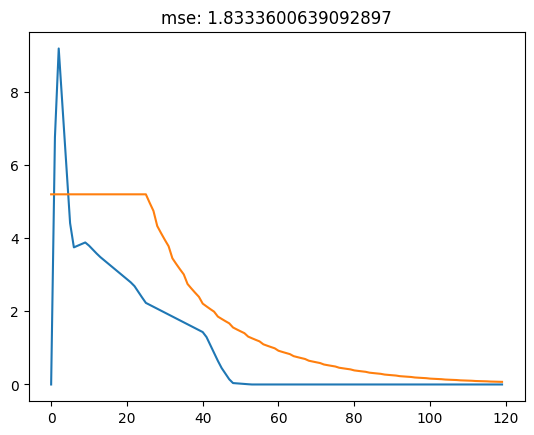

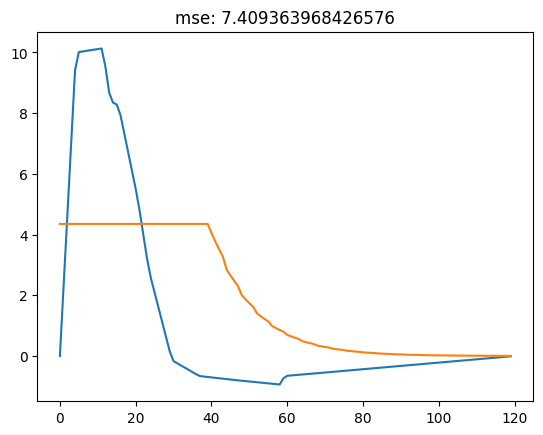

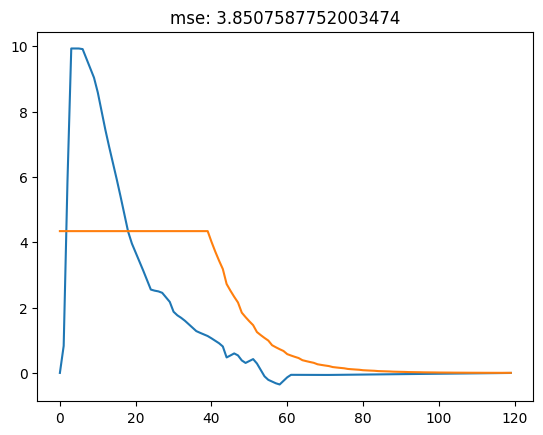

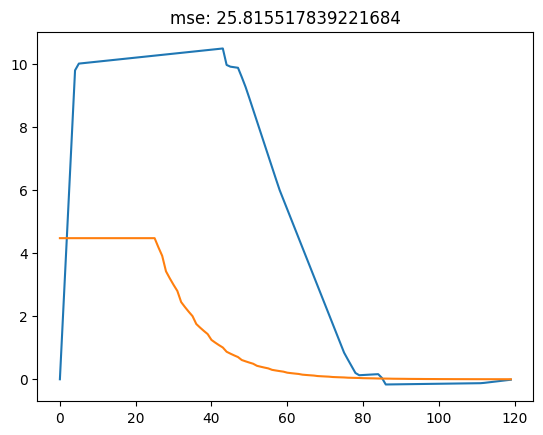

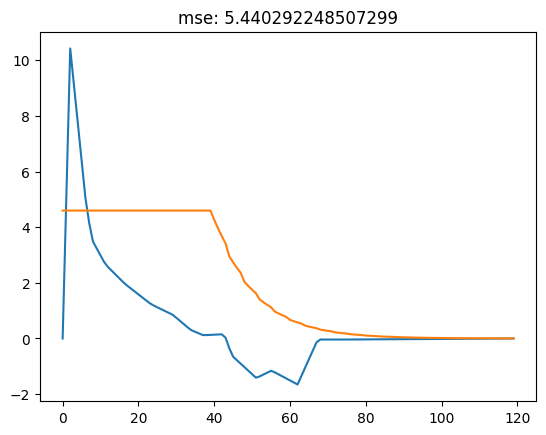

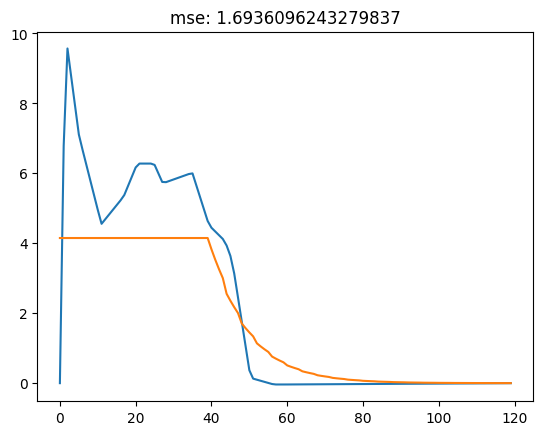

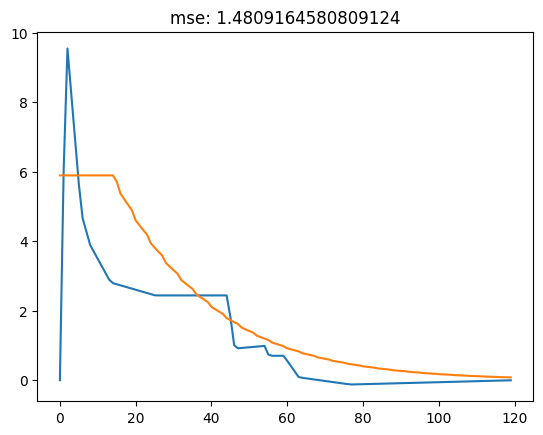

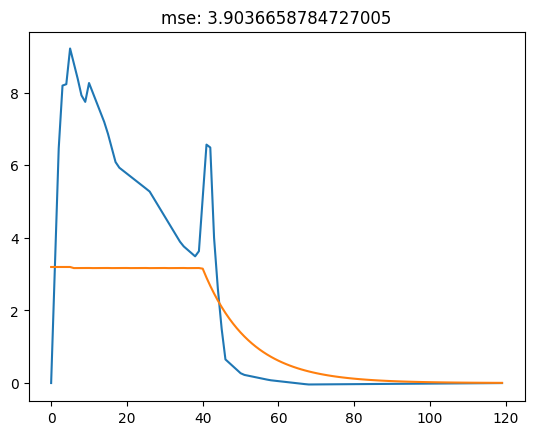

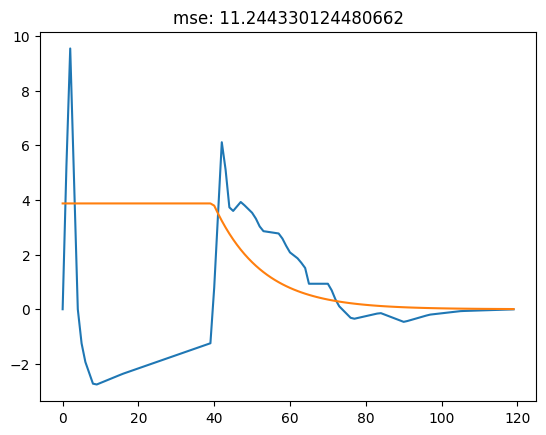

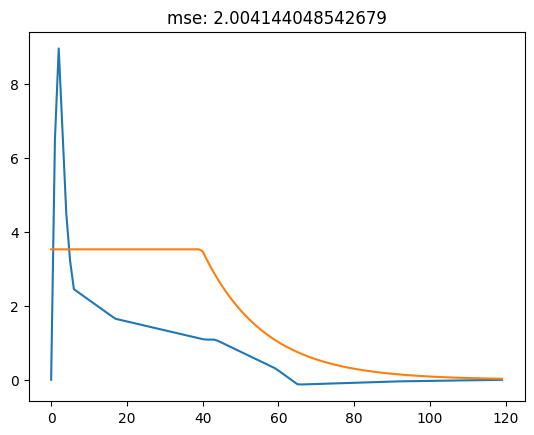

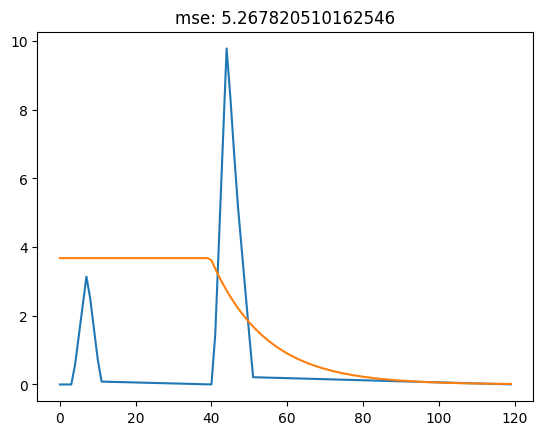

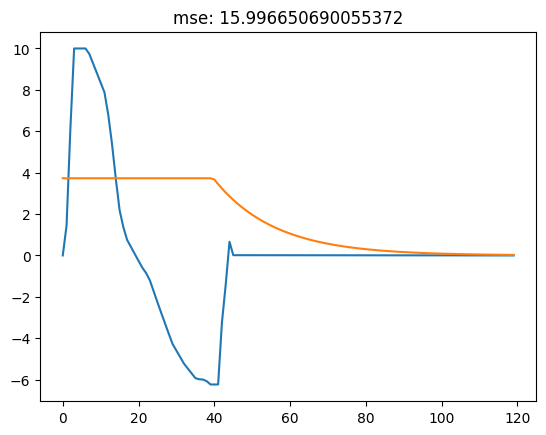

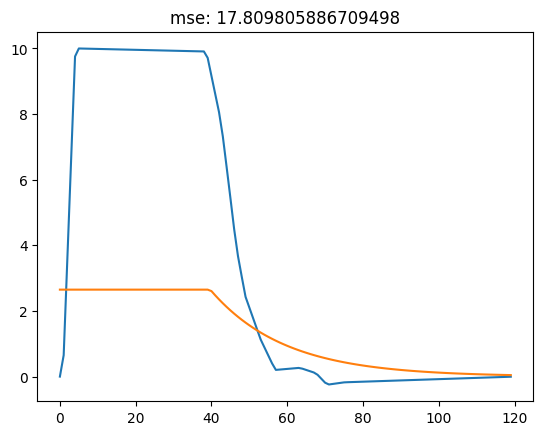

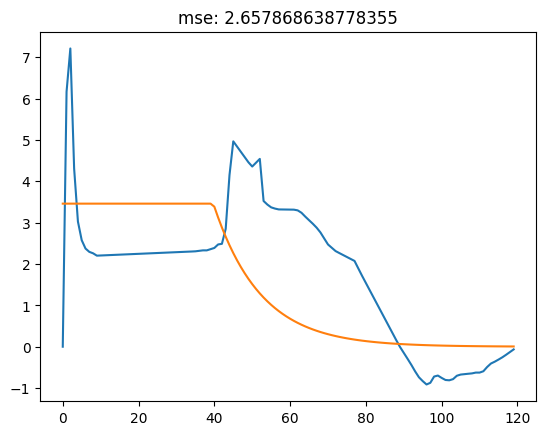

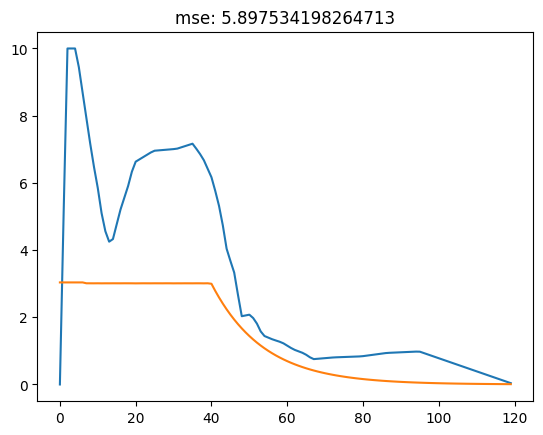

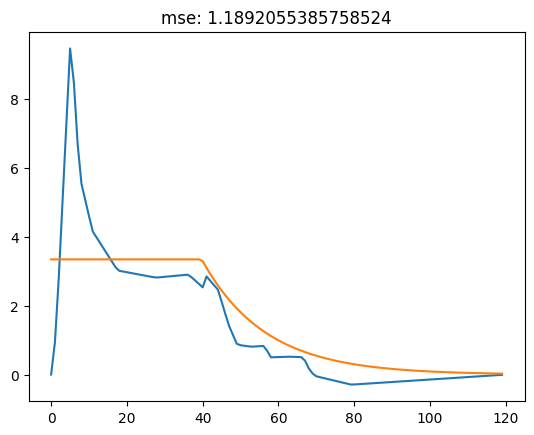

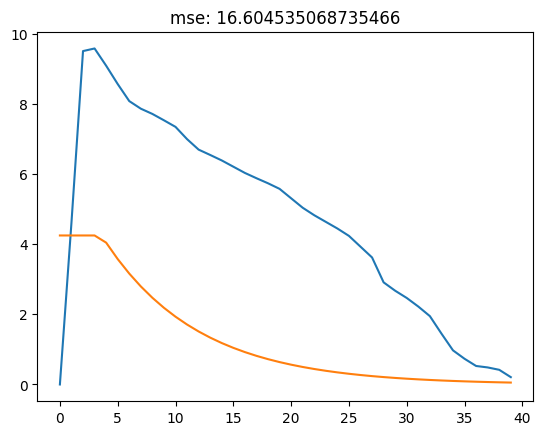

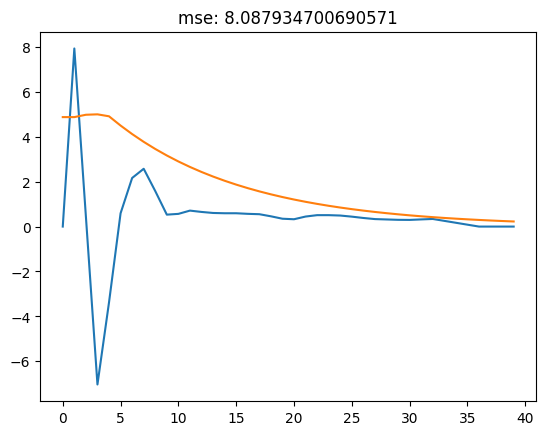

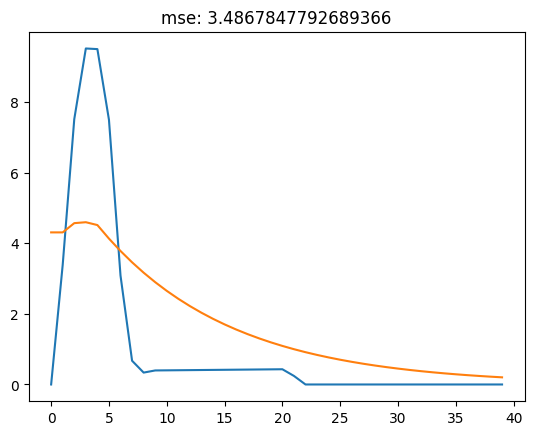

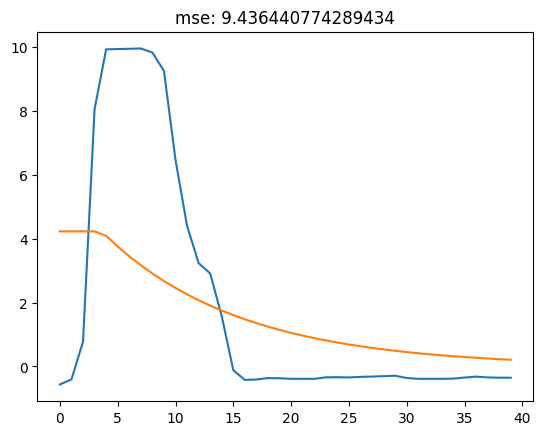

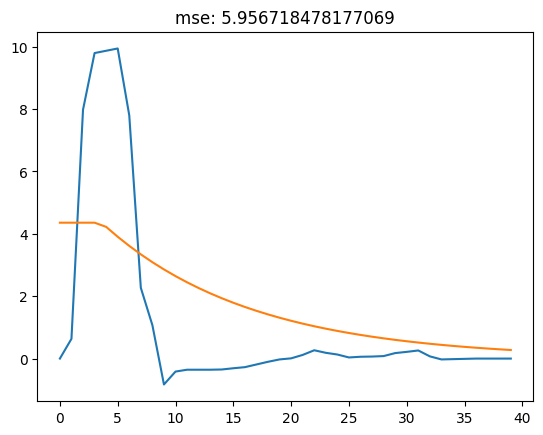

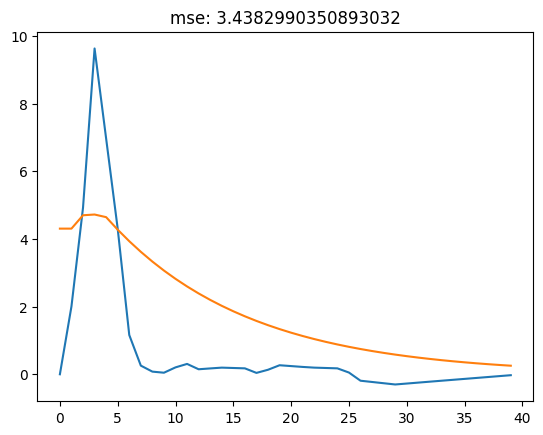

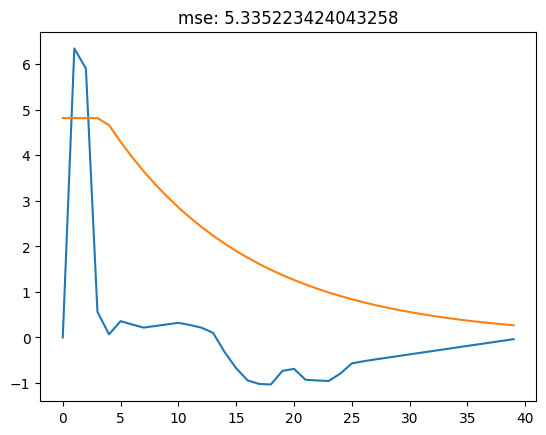

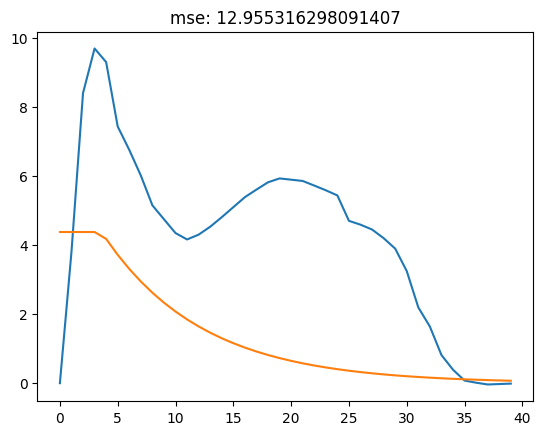

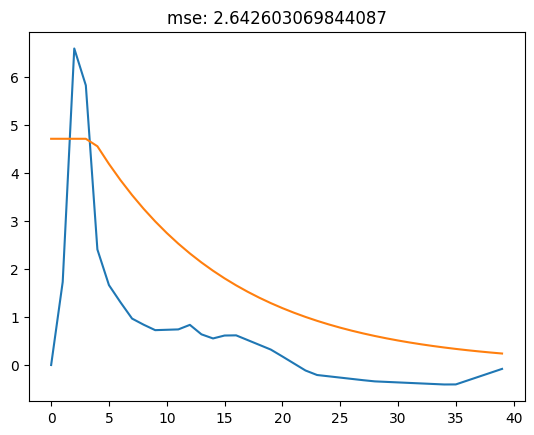

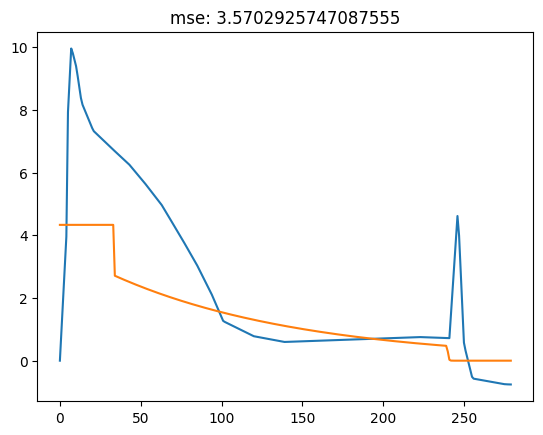

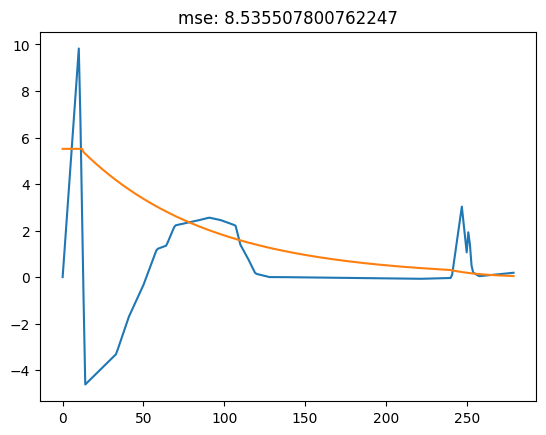

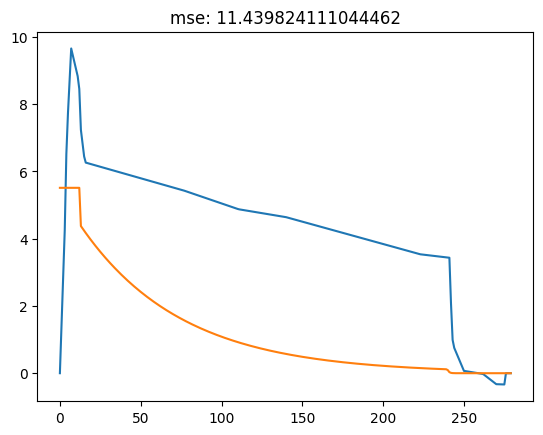

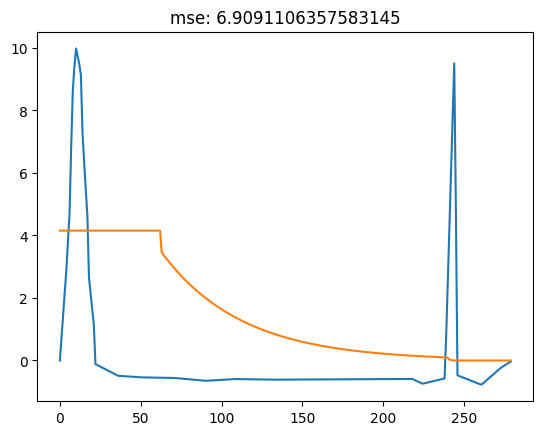

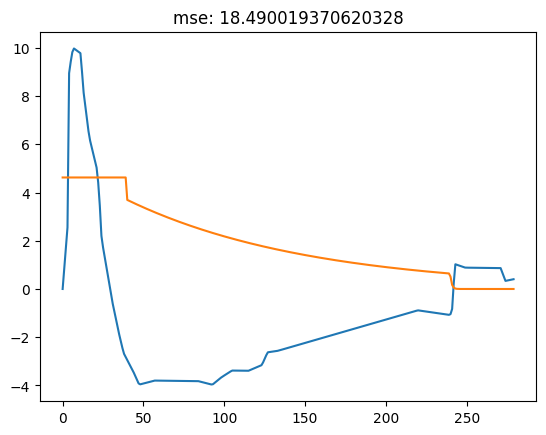

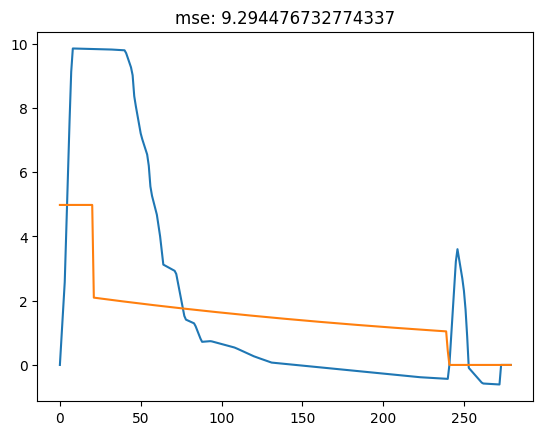

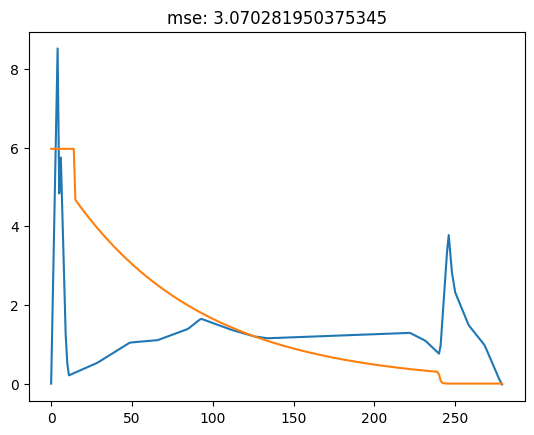

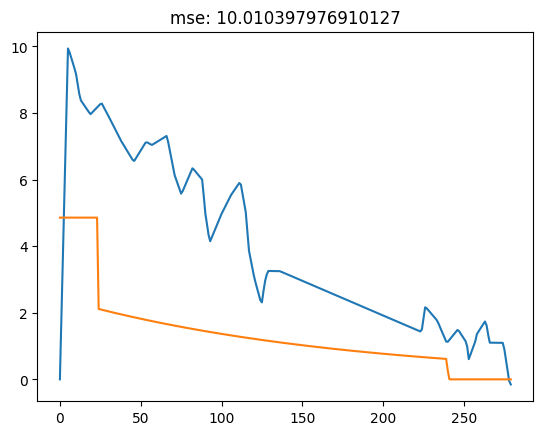

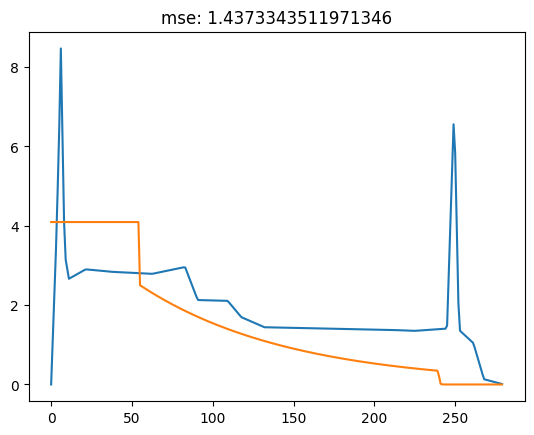

In [10]:
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

args.interpolation_factor = 4

data = pd.read_csv('perez-fornos-2012.csv')  

def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

file_path = 'baseline_persubject_025interp.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list
            

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]

    # gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
    gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)
    pred = np.interp(np.linspace(0, len(pred)-1, len(gt_curves_val)), range(len(pred)), pred)
    
    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure()
    plt.plot(gt_curves_val)
    plt.plot(pred)
    plt.title('mse: '+str(mse[i]))

In [11]:
for cond in range(5):
    mse_,r2_,cor_ = [],[],[]
    for subj in range(9):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('cond', cond)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3), end=' ')
    # print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

6.001 +- 4.648 0.656 +- 0.39
6.96 +- 7.175 0.688 +- 0.264
7.33 +- 5.833 0.541 +- 0.399
7.549 +- 4.472 0.585 +- 0.212
8.084 +- 4.899 0.455 +- 0.3


In [14]:
print(round(np.mean([i for i in mse.values()]), 3), '+-', round(np.std([i for i in mse.values()]), 3))
print(round(np.mean([i for i in cor.values()]), 3), '+-', round(np.std([i for i in cor.values()]), 3))

7.185 +- 5.541
0.585 +- 0.332


In [15]:
for subj in range(9):
    mse_,r2_,cor_ = [],[],[]
    for cond in range(5):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('subject', subj)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3), end = ' ')
    # print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

6.14 +- 5.375 0.838 +- 0.1
10.358 +- 2.144 -0.031 +- 0.091
4.185 +- 3.674 0.768 +- 0.095
7.212 +- 1.333 0.509 +- 0.212
9.597 +- 6.344 0.467 +- 0.274
13.992 +- 7.589 0.78 +- 0.141
4.792 +- 1.751 0.322 +- 0.293
6.686 +- 4.253 0.82 +- 0.161
1.703 +- 0.504 0.793 +- 0.095


### plots

In [ ]:
# validation plots
# ct, r2, mse, cor = 0,0,0,0
ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    args.exper_dur = 60
    args.stim_dur = 20
    if i <= 8: args.EAR = 20
    elif i <= 17: args.EAR = 5
    elif i <= 26: args.EAR = 60
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 20
        args.stim_dur = 2
    else:
        args.EAR = 20
        args.exper_dur = 140
        args.stim_dur = 120

    DFR_optimized, PER_optimized, PFO_optimized, brightness_scale_optimized = results_dict[i]
    curve = np.nan_to_num(data['time_series'][i],0)[4:args.exper_dur+4]
    pred = make_prediction(curve, DFR_optimized, PER_optimized, PFO_optimized, brightness_scale_optimized)
    mse[i] = mean_squared_error(curve, pred)
    r2[i] = r2_score(curve, pred)
    cor[i] = corr(curve, pred)
    plt.figure()
    plt.plot(curve)
    plt.plot(pred)
    
    # if ct == 9:
    #     print('mse:', round(mse/9, 5))
    #     print('r2:', round(r2/9, 5))
    #     print('cor:', round(cor/9, 5))
    #     ct, r2, mse, cor = 0,0,0,0

## eval 0.25

In [ ]:
def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

file_path = '/hdd/yuchen/baseline_test025.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list

In [ ]:
args.interpolation_factor = 4

data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]

    # gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
    gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)
    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure()
    plt.plot(gt_curves_val)
    plt.plot(pred)
    plt.title('mse: '+str(mse[i]))


In [ ]:
for cond in range(5):
    mse_,r2_,cor_ = [],[],[]
    for subj in range(9):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    print('cond', cond)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3))
    print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

In [ ]:
for subj in range(9):
    mse_,r2_,cor_ = [],[],[]
    for cond in range(5):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    print('subject', subj+1)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3))
    print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

## eval perpanel 0.5 interp

In [ ]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [ ]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [ ]:
file_path = '/hdd/yuchen/baseline_perpanel.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list
            
def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

In [ ]:
args.interpolation_factor = 2

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]
    gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)
    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure()
    plt.plot(gt_curves_val)
    plt.plot(pred)
    plt.title('panel: ' + str(i+1) + '; mse: '+str(round(mse[i], 5)))


## eval perpanel 0.25 interp

In [ ]:
import pandas as pd
data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')  

In [ ]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 4 # number of frames sampled every second
    
args = Args()

def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()

In [ ]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_


In [ ]:
file_path = '/hdd/yuchen/baseline_perpanel-025interp.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list

args.interpolation_factor = 4

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]
    # gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
    gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0) 
    

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)
    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)

    plt.figure()
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4), gt_curves_val)
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4), pred)
    plt.title('panel: ' + str(i+1) + '; mse: '+str(round(mse[i], 5)))


## per-condition 0.5 interp

In [ ]:
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [ ]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [ ]:
stim_info = {}
# EAR, exper_dur, stim_dur
for i in range(9): stim_info[i] = [20, 30, 10]
for i in range(9,18): stim_info[i] = [5, 30, 10]
for i in range(18,27): stim_info[i] = [60, 30, 10]
for i in range(27,36): stim_info[i] = [20, 10, 1]
for i in range(36,45): stim_info[i] = [20, 70, 60]

def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()
    

file_path = '/hdd/yuchen/baseline_percondition.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list

In [ ]:
import pandas as pd
data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')  

In [ ]:
args.interpolation_factor = 2

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]
    gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*4+6].to_numpy().astype('float64'), 0)
    # gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)

    interpolated_x = np.linspace(0, 1, len(pred)*2)
    pred = np.interp(interpolated_x, np.linspace(0, 1, len(pred)), pred)
    gt_curves_val = np.interp(interpolated_x, np.linspace(0, 1, len(gt_curves_val)), gt_curves_val)

    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure(figsize=(3,3))
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4),gt_curves_val, color='blue')
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4),pred, color='red')
    plt.title('panel: ' + str(i+1) + ' mse: '+str(round(mse[i], 5)))


In [ ]:
for cond in range(5):
    mse_,r2_,cor_ = [],[],[]
    for subj in range(9):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('cond', cond)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3), end=' ')
    # print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

In [ ]:

for subj in range(9):
    mse_,r2_,cor_ = [],[],[]
    for cond in range(5):
        idx = cond*9 + subj
        mse_.append(mse[idx])
        r2_.append(r2[idx])
        cor_.append(cor[idx])
    # print('subject', subj)
    print(round(np.mean(mse_), 3), '+-', round(np.std(mse_), 3), end=' ')
    # print(round(np.mean(r2_), 3), '+-', round(np.std(r2_), 3))
    print(round(np.mean(cor_), 3), '+-', round(np.std(cor_), 3))

## per-condition 0.25 interp

In [ ]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [ ]:
import pandas as pd
data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')  

In [ ]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [ ]:
import numpy as np
from scipy.optimize import minimize

args.interpolation_factor = 4

stim_info = {}
# EAR, exper_dur, stim_dur
for i in range(9): stim_info[i] = [20, 30, 10]
for i in range(9,18): stim_info[i] = [5, 30, 10]
for i in range(18,27): stim_info[i] = [60, 30, 10]
for i in range(27,36): stim_info[i] = [20, 10, 1]
for i in range(36,45): stim_info[i] = [20, 70, 60]

def make_prediction(new_data, PER, PFO, PFD, brightness_scale):
    model_output = brightness_equ(PER, PFO, PFD, brightness_scale)
    return model_output
    
def corr(actual, pred, eps=1e-8):
    pred = np.array(pred)
    actual = np.array(actual)
    
    actual = (actual - actual.mean()) / (actual.std(ddof=0) + eps)
    pred = (pred - pred.mean()) / (pred.std(ddof=0) + eps)
    return (actual * pred).mean()
    

file_path = '/hdd/yuchen/baseline_percondition_025interp.txt'
results_dict = {}

with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split(':')
        if row[0].split('-')[0] != '2024':
            key, value = row
            key = int(key)
            value_string = value.strip(" []")
            value_list = [float(num.split(',')[0]) for num in value_string.split()]
            results_dict[key] = value_list
            


In [ ]:

ct = 0
mse = {}
cor = {}
r2 = {}
for i in range(0, 45):
    print(i)
    ct += 1
    if i <= 8: 
        args.EAR = 20
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 17: 
        args.EAR = 5
        args.exper_dur = 30
        args.stim_dur = 10
    elif i <= 26: 
        args.EAR = 60
        args.exper_dur = 30
        args.stim_dur = 10  
    elif i<=35: 
        args.EAR = 20
        args.exper_dur = 10
        args.stim_dur = 1
    else: 
        args.EAR = 20
        args.exper_dur = 70
        args.stim_dur = 60

    PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized = results_dict[i]
    gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*4+6].to_numpy().astype('float64'), 0)

    pred = make_prediction(gt_curves_val, PER_optimized, PFO_optimized, PFD_optimized, brightness_scale_optimized)

    # interpolated_x = np.linspace(0, 1, len(pred)*2)
    # pred = np.interp(interpolated_x, np.linspace(0, 1, len(pred)), pred)
    # gt_curves_val = np.interp(interpolated_x, np.linspace(0, 1, len(gt_curves_val)), gt_curves_val)

    mse[i] = mean_squared_error(gt_curves_val, pred)
    r2[i] = r2_score(gt_curves_val, pred)
    cor[i] = corr(gt_curves_val, pred)
    plt.figure(figsize=(3,3))
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4),gt_curves_val, color='blue')
    plt.plot(np.linspace(0, args.exper_dur-1, args.exper_dur*4),pred, color='red')
    plt.title('panel: ' + str(i+1) + ' mse: '+str(round(mse[i], 5)))


## per-subject 0.25 interp